### Machine learning for distribution line's flashover predictions

Author: Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)

University of Split, FESB, Department of Power Engineering, R. Boskovica 32, HR21000, Split, Croatia.

In [1]:
import warnings

In [2]:
# Ignore FutureWarning messages
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [4]:
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibrationDisplay

In [5]:
from scipy import interpolate
from scipy import optimize

In [6]:
# Private modules
import distlines
import sandbox
import utils

In [7]:
# Figure style using matplotlib
plt.style.use('ggplot')
# Figure style using seaborn
#sns.set_theme(context='paper', style='darkgrid', font_scale=1.1)
#sns.set_style('ticks', {'xtick.direction':'out', 'ytick.direction':'out'})

### Distribution line indirect lightning strikes

There are, generally speaking, a total of five different modes in which lightning strike interacts with a distribution line, which can be subdivided into: (a) direct strikes and (b) indirect strikes. A direct strike can (a1) end up on a phase conductor when the shield wire is not present, or (a2) it can circumvent the shield wire to strike a phase conductor, which is known as the shielding failure. Also, a direct strike can (a3) end up on a shield wire (when it is present on the line), which can result with a backflashover incident. Furthermore, an indirect lightning strike into the near-by ground (up to several hundred meters from the line) can also initiate a flashovers (b1) with or (b2) without the presence of a shield wire, due to the electromagnetic pulse that is radiated from the lightning channel and coupled by the line conductors.

In [8]:
# INPUT DATA:
# ===========
# Number of random samples:
N = 1000

# Multiple distribution lines (example).
# ---------------------------
# Geometry is in meters.
y = np.asarray([12., 15.], dtype=float)
h = y + 1.5  # shield wire height
# distance between shield wires
sg = np.repeat(3., repeats=len(y))

# Critical flashover voltage of the line (kV).
line_cfo = np.asarray([150., 160.], dtype=float)

Distribution lines' lightning flashovers data set, for training the subsequent machine learning model, is generated by means of the Monte~Carlo simulation. Statistical probability of lightning flashovers on distribution lines depends on several important parameters, each of which with its own statistical distribution: (1) lightning current amplitude, (2) lightning return stroke velocity, (3) lightning strike distance from the line, (4) OHL tower's grounding impedance, (5) shield wire's presence on the tower, and (6) EGM model type.

In [9]:
# Monte Carlo simulations.
Un = 20.; R0 = 10.; rho = 100.; r_tower = 0.5
args = (Un, R0, rho, r_tower)
# Model parameters:
kwargs= {# user-defined parameters
    'tower_model': 'cylindrical',
    'model_bfr': 'hileman',
    'model_bfr_random': True,
}
# Generate dataset:
data = distlines.generate_dataset(N, h, y, sg, line_cfo, *args, 
                                  export=False, **kwargs)
# View data sample:
data.head()

,dist,ampl,front,shield,veloc,Ri,EGM,ind,CFO,height,flash
0,355.172227,32.940755,4.094994,0,432.203593,58.455447,Anderson,rusk,150.0,12.0,0.0
1,198.275544,23.124677,4.391168,1,478.992535,71.931285,Love,rusk,150.0,12.0,0.0
2,60.925967,29.514052,3.306096,0,273.999755,63.294164,AW,rusk,150.0,12.0,1.0
3,260.524918,21.251026,2.735565,0,488.122426,69.004783,Love,rusk,150.0,12.0,0.0
4,154.560265,43.138760,3.712126,0,249.096213,55.392052,Love,rusk,150.0,12.0,0.0


In [10]:
# Group data by distribution lines:
groups = data.groupby('height')

# EXAMPLE: 15 m high dist. line
# -----------------------------
g = groups.get_group(15)
g.reset_index(inplace=True)

In [11]:
print(f"Pct. of flashovers: {(g['flash'].sum()/len(g['flash']))*100.:.1f} %")

Pct. of flashovers: 18.2 %


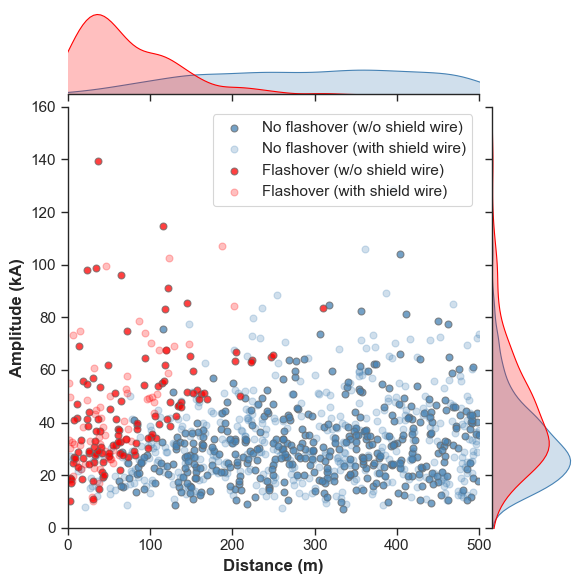

In [12]:
# Plot realizations with marginal distributions.
sandbox.plot_dataset(g['dist'], g['ampl'], g['flash'], g['shield'], 
                     'Distance (m)', 500, 'Amplitude (kA)', 160,
                     '3axis_output.png', save_fig=True)

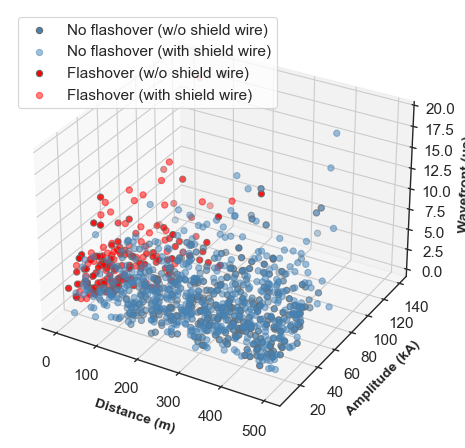

In [13]:
# Plot data in 3D.
sandbox.plot_dataset_3d(g['dist'], g['ampl'], g['front'], 
                        g['flash'], g['shield'], save_fig=True)

### Flashover predictions with Support Vector Machine based ensemble

We will start with two features: distance of the strike point and lightning current amplitude, and we'll add other features later. It is expected that the prediction accuracy of the model will increase with adding other features. Additional features of particular interest are: height of the distribution line, presence of the shield wires, and impulse impedance of the tower grounding.

In [14]:
# Prepare training data set for scikit-learn.
X_data = g[['dist', 'ampl']]  # add features here
y_data = g['flash']

In [15]:
# Stratified Shuffle Split dataset into train and test sets.
X, y, X_test, y_test = sandbox.train_test_shuffle_split(X_data, y_data)

Ensemble learning is a machine learning paradigm in which multiple models (often called base models) are trained to tackle the same (classification) problem and then combined, by aggregating predictions or with a meta-model, to yield better performance. Models can be combined in different ways, leading to different techniques for creating ensembles.

Bagging ensemble is built by means of bootstrap aggregating multiple base models, which reduces overall variance and helps avoid overfitting. Each base model is individually trained on the subset of training samples, drawn with replacement from the original set (i.e. bootstrap sample). Individual predictions of the base models are then aggregated by averaging their prediction probabilities.

##### Bagging Ensemble Classifier from SVMs

In [16]:
# Choose the bagging classifier variant:
variant = 'B'

if variant == 'A':
    # Off-the-shelf bagging classifier.
    n_models = 5  # Enter number of models for the ensemble.
    # Model training with hyperparameters optimization.
    search = sandbox.bagging_classifier(n_models, X, y, sample_pct=0.8)
elif variant == 'B':
    # Hand-made bagging classifier.
    n_models = 3  # Enter number of models for the ensemble.
    # Model training with hyperparameters optimization.
    search = sandbox.bagging_ensemble_svm(
        n_models, X, y, sample_pct=0.9, 
        weighted=False, sampling='Stratified',
        weights_loss_type='balanced_focal_loss'
    )
else:
    raise NotImplementedError(f'Variant: {variant} is not recognized!')

Train model 1 of 3:
Working ...
Execution time (hour:min:sec): 0:00:02.186043
estimator__C :: 78.76449005898691
estimator__gamma :: auto
estimator__kernel :: linear
preprocess :: StandardScaler()
Train model 2 of 3:
Working ...
Execution time (hour:min:sec): 0:00:31.560319
estimator__C :: 15.04860792734013
estimator__gamma :: scale
estimator__kernel :: linear
preprocess :: StandardScaler()
Train model 3 of 3:
Working ...
Execution time (hour:min:sec): 0:00:40.104197
estimator__C :: 1.602611163670763
estimator__gamma :: auto
estimator__kernel :: linear
preprocess :: None
Aggregating predictions:
With equal weights.
Create voting ensemble:
Working ...
Done.


In [17]:
# Prepare meshgrid for prediction.
XMAX = 400.
YMAX = 160.
xx = np.linspace(0, XMAX, 100)    # x-axis (distance)
yy = np.linspace(0, YMAX, 100).T  # y-axis (amplitude)
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]
# Prediction probabilities on meshgrid.
probas = search.predict_proba(Xfull)[:,1]
zz = probas.reshape(xx.shape)

__Support vectors__

SVM (as a base estimator) provides support vectors which serve as a scaffolding around the curve of limiting parameters (CLP). The CLP, at the same time, features prominently in the process of statistical insulation coordination; see IEC TR 60071-4:2004 for more information.

In [18]:
# Extract support vectors from the base models
vectors = sandbox.support_vectors(variant, search, n_models, X, y)

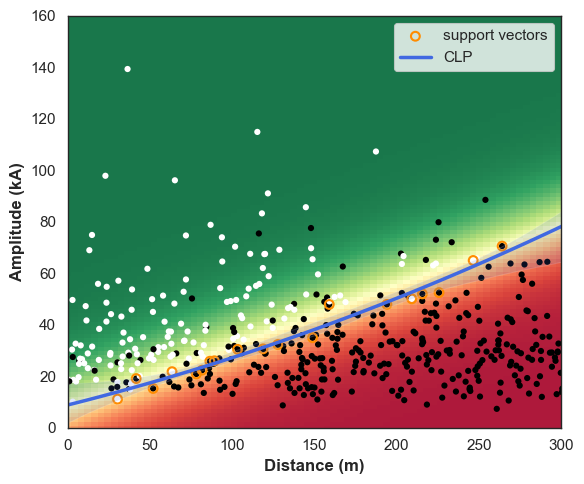

In [19]:
# Curve of Limiting Parameters (CLP).
fig, ax = plt.subplots(figsize=(6,5))
ax.pcolormesh(xx, yy, zz, cmap=plt.cm.RdYlGn, shading='nearest', alpha=0.9)
# Show data from the training set.
ax.scatter(X.values[:,0], X.values[:,1], 
           c=y, edgecolors='none', cmap=plt.cm.bone, s=20)
# Indicate support vectors.
ax.scatter(vectors[:,0], vectors[:,1], facecolor='none',  
           edgecolor='darkorange', s=40, linewidths=1.5, label='support vectors')
# Fit and plot CLP regression curve through the support vectors.
sns.regplot(x=vectors[:,0], y=vectors[:,1], fit_reg=True, order=2,  
            truncate=False, scatter=False, color='royalblue',
            line_kws={'lw': 2.5},
            ax=ax, label='CLP')
ax.legend(loc='upper right', frameon='fancy', fancybox=True)
ax.set_xlabel('Distance (m)', fontweight='bold')
ax.set_ylabel('Amplitude (kA)', fontweight='bold')
ax.set_xlim(0,300)
ax.set_ylim(0,160)
fig.tight_layout()
plt.savefig('classify_plot.png', dpi=600)
plt.show()

CLP as a second-degree polinomial regression

In [20]:
# Analysis of CLP as a regression curve through the support vectors.
y_vectors = vectors[:,1]
X_vectors = np.c_[vectors[:,0], vectors[:,0]**2]  # 2-order poly
X_vectors = sm.add_constant(X_vectors)  # add intercept
# Least squares regression:
ols = sm.OLS(endog=y_vectors, exog=X_vectors).fit(method='qr')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     259.6
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           6.37e-13
Time:                        13:56:52   Log-Likelihood:                -47.032
No. Observations:                  19   AIC:                             100.1
Df Residuals:                      16   BIC:                             102.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8577      3.110      2.848      0.012       2.264      15.451
x1             0.1597      0.050      3.167      0.006       0.053       0.267
x2             0.0002      0.000      1.398      0.181      -0.000       0.001
==============================================================================
Omnibus:                        3.553   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                1.956
Skew:                           0.768   Prob(JB):                        0.376
Kurtosis:                       3.329   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
v = np.linspace(0, XMAX, 100)
x_data = np.c_[v, v**2]
x_data = sm.add_constant(x_data)
# Predict on new data with 95% confidence and prediction intervals:
predictions = ols.get_prediction(x_data).summary_frame(alpha=0.05)

In [22]:
predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,8.857732,3.110384,2.264011,15.451452,-0.502976,18.218439
1,9.506967,2.921926,3.312760,15.701174,0.423251,18.590683
2,10.163939,2.739956,4.355491,15.972386,1.338761,18.989116
3,10.828647,2.564616,5.391903,16.265390,2.243550,19.413743
4,11.501091,2.396075,6.421639,16.580543,3.137687,19.864495


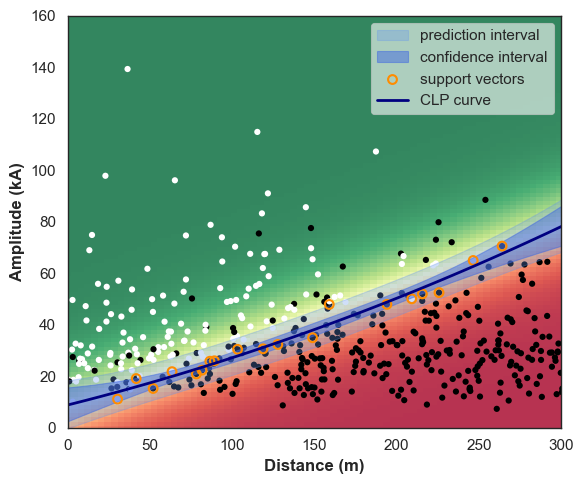

In [23]:
sandbox.regression_plot(X.values, y.values, 
                        vectors, v, predictions, 
                        xx, yy, zz, save_fig=True)

Computing risk from the CLP curve

In [24]:
args = (0., XMAX, 31.1, 0.484)
zz_pdf = sandbox.amplitude_distance_bivariate_pdf(yy, xx, *args)

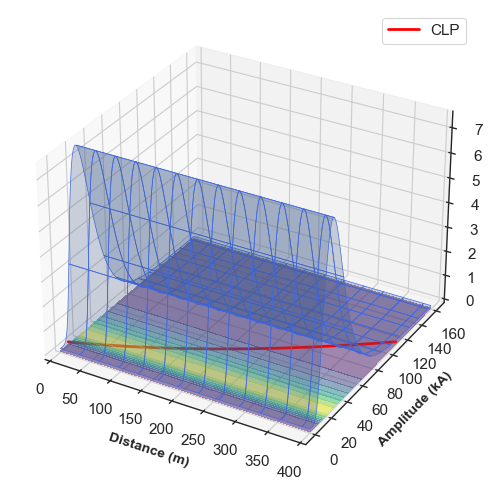

In [25]:
offset = -1e-6
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
# Bivariate probability density function (of distances and amplitudes).
ax.plot_surface(xx, yy, zz_pdf, edgecolor='royalblue', lw=0.5,
                rstride=8, cstride=8, alpha=0.25)
# CLP regression curve through the support vectors.
ax.plot(v, predictions['mean'], c='red', lw=2, label='CLP')
# Projection of the PDF surface on the figure floor.
ax.contourf(xx, yy, zz_pdf, zdir='z', offset=offset, cmap='viridis', alpha=0.5)
ax.set_xlabel('Distance (m)', fontweight='bold', fontsize=10)
ax.set_ylabel('Amplitude (kA)', fontweight='bold', fontsize=10)
ax.set_zlabel('Probability', fontweight='bold', fontsize=10)
ax.set_xlim(0, XMAX)
ax.legend()
fig.tight_layout()
plt.show()

In [26]:
# The total risk is the value of a double integral underneath 
# the bivariate probability density function (of distances and 
# amplitudes), computed only above the CLP curve. 
# CLP parameters
clp = ols.params
# Distance integration limits
xmin, xmax = 0., XMAX
# Risk from double integral:
risk = sandbox.risk_from_clp(clp, xmin, xmax)
print(f'Risk: {risk:.4f}')

Risk: 0.3248


Additional different CLP curve regression possibilities

In [27]:
# Spline regression:
spline = SplineTransformer(degree=2, n_knots=3, extrapolation='continue')
X_spline = spline.fit_transform(vectors[:,0].reshape(-1, 1))
spl = sm.OLS(endog=y_vectors, exog=X_spline).fit()
spl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     178.8
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           5.82e-12
Time:                        13:56:54   Log-Likelihood:                -46.137
No. Observations:                  19   AIC:                             100.3
Df Residuals:                      15   BIC:                             104.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.5471      5.910     -0.262      0.797     -14.143      11.049
x2            26.5443      2.362     11.236      0.000      21.509      31.580
x3            47.8763      2.817     16.996      0.000      41.872      53.881
x4            90.7264      6.848     13.249      0.000      76.131     105.322
==============================================================================
Omnibus:                       12.270   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.913
Skew:                           1.384   Prob(JB):                      0.00704
Kurtosis:                       5.203   Cond. No.                         6.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
X_spline_new = spline.transform(v.reshape(-1, 1))
# Predict on new data with 95% confidence and prediction intervals:
predictions = spl.get_prediction(X_spline_new).summary_frame(alpha=0.05)

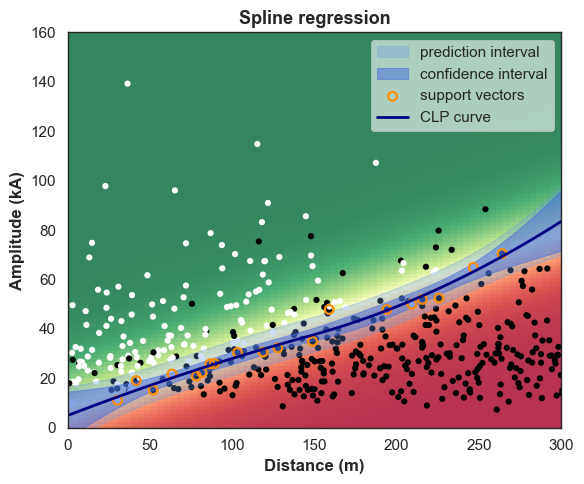

In [29]:
sandbox.regression_plot(X.values, y.values, vectors, v, predictions, xx, yy, zz, 
                        'Spline regression')

##### Classification metrics and calibration

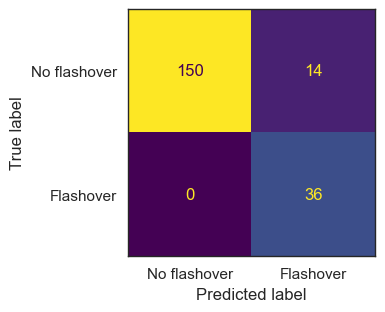

In [30]:
# Plot confusion matrix for estimator.
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_estimator(
    search, X_test, y_test, 
    display_labels=['No flashover', 'Flashover'],
    #cmap=plt.cm.RdYlBu,
    colorbar=False,
    ax=ax,
)
fig.tight_layout()
plt.savefig('confusion.png', dpi=600)
plt.show()

In [31]:
y_test_scores = search.predict(X_test)

# Display classification report:
print(classification_report(
      y_test, y_test_scores, 
      target_names=['No flashover', 'Flashover']))

              precision    recall  f1-score   support

No flashover       1.00      0.91      0.96       164
   Flashover       0.72      1.00      0.84        36

    accuracy                           0.93       200
   macro avg       0.86      0.96      0.90       200
weighted avg       0.95      0.93      0.93       200



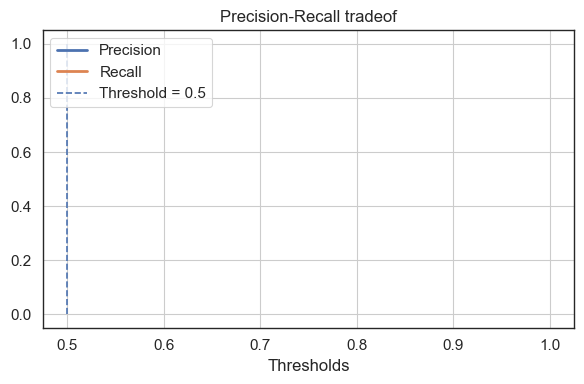

In [32]:
# Precision - Recall trade off for classifier calibration.
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_scores)

fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.grid()
fig.tight_layout()
#plt.savefig('precision-recall.png', dpi=600)
plt.show()

From the precision recall trade-off diagram it can be seen that the precision of the classifier can be significantly increased on the expense of only slightly reduced recall, by pushing the threshold level up from the baseline value.

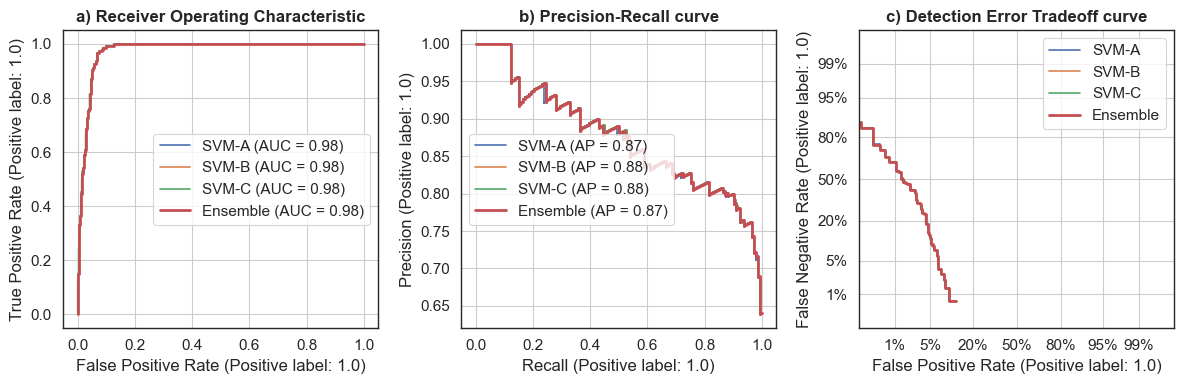

In [33]:
# ROC, PR & DET curves
alphabet = 'ABCDEFGHJKLMNPQRSTUVWXYZ'
fig, ax = plt.subplots(1, 3, figsize=(12,4))
for id, base_estimator in zip(alphabet, search.estimators_):
    RocCurveDisplay.from_estimator(
        base_estimator, X, y, name='SVM-'+id, ax=ax[0])
    PrecisionRecallDisplay.from_estimator(
        base_estimator, X, y, name='SVM-'+id, ax=ax[1])
    DetCurveDisplay.from_estimator(
        base_estimator, X, y, name='SVM-'+id, ax=ax[2])
RocCurveDisplay.from_estimator(
    search, X, y, name='Ensemble', ax=ax[0], lw=2)
PrecisionRecallDisplay.from_estimator(
    search, X, y, name='Ensemble', ax=ax[1], lw=2)
DetCurveDisplay.from_estimator(
    search, X, y, name='Ensemble', ax=ax[2], lw=2)
ax[0].legend(loc='center right')
ax[1].legend(loc='center left')
ax[2].legend(loc='upper right')
ax[0].set_title('a) Receiver Operating Characteristic', fontweight='bold')
ax[1].set_title('b) Precision-Recall curve', fontweight='bold')
ax[2].set_title('c) Detection Error Tradeoff curve', fontweight='bold')
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.tight_layout()
plt.savefig('roc_pr_det_curves.png', dpi=600)
plt.show()

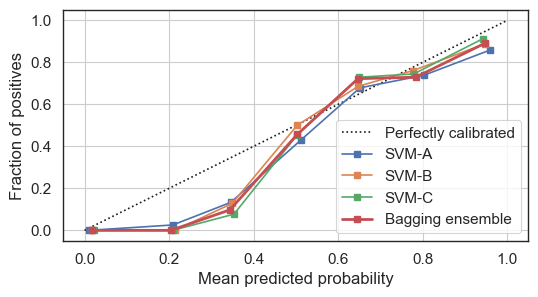

In [34]:
# Callibration plot
fig, ax = plt.subplots(figsize=(6,3))
for id, base_estimator in zip(alphabet, search.estimators_):
    CalibrationDisplay.from_estimator(
        base_estimator, X, y, n_bins=7, name='SVM-'+id, ax=ax)
CalibrationDisplay.from_estimator(
    search, X, y, n_bins=7, name='Bagging ensemble', ax=ax, lw=2)
ax.grid()
plt.show()

##### Marginal distributions

Machine learning model enables deriving a cumulative distribution function of the distribution line's insulation flashover (i.e. performance function), which features prominently in the risk of insulation flashover analysis.

In [35]:
yv = np.linspace(0, YMAX, 200)
distances = [0., 50., 100., 150., 200., 250., 350.]
y_hat = {}
for d in distances:
    xv = np.array([d]*yv.size)
    X_values = np.c_[xv, yv]
    y_hat[d] = search.predict_proba(X_values)

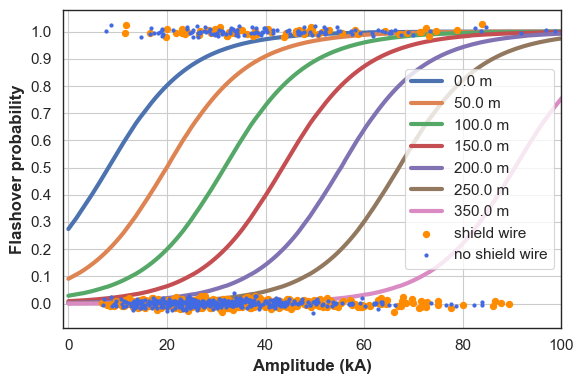

In [36]:
# Plot probability distributions for different distances
sandbox.marginal_plot(distances, yv, y_hat, g, 'ampl', 'Amplitude (kA)', 
                      save_fig=True)

##### Risk of flashover analysis

In [37]:
# PDF of lightning current amplitudes
mu = 31.1
sigma = 0.484
pdfi = distlines.lightning_current_pdf(yv, mu, sigma)

# Risk of flashover analysis
risk_values = {}
for d in distances:
    risk = distlines.risk_of_flashover(yv, y_hat[d][:,1])
    print(d, '=>', risk.round(4))
    risk_values[d] = risk

0.0 => 0.8951
50.0 => 0.7386
100.0 => 0.5183
150.0 => 0.3149
200.0 => 0.1735
250.0 => 0.0903
350.0 => 0.0227


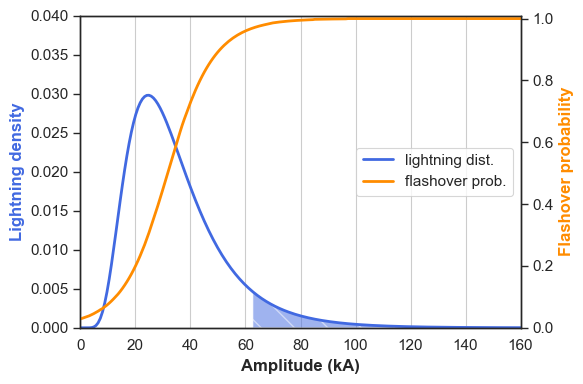

In [38]:
D = 100  # distance
fig, ax = plt.subplots(figsize=(6,4))
ax_twin = ax.twinx()  # second y-axis
l1 = ax.plot(yv, pdfi, c='royalblue', lw=2, label='lightning dist.')
idx = np.argwhere(yv >= 62.)[0][0]
ax.fill_between(yv[idx:], pdfi[idx:], fc='royalblue', alpha =0.5, hatch='\\')
ax.set_xlim(0, yv.max())
ax.set_ylim(0, 0.04)
l3 = ax_twin.plot(yv, y_hat[D][:,1], c='darkorange', lw=2, label='flashover prob.')
lns = l1 + l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')
ax.set_xlabel('Amplitude (kA)', fontweight='bold')
ax.set_ylabel('Lightning density', fontweight='bold')
ax.yaxis.label.set_color('royalblue')
ax_twin.set_ylabel('Flashover probability', fontweight='bold')
ax_twin.yaxis.label.set_color('darkorange')
ax_twin.set_ylim(0, 1.01)
ax.grid(axis='x')
fig.tight_layout()
plt.savefig('safety-factor.png', dpi=600)
plt.show()

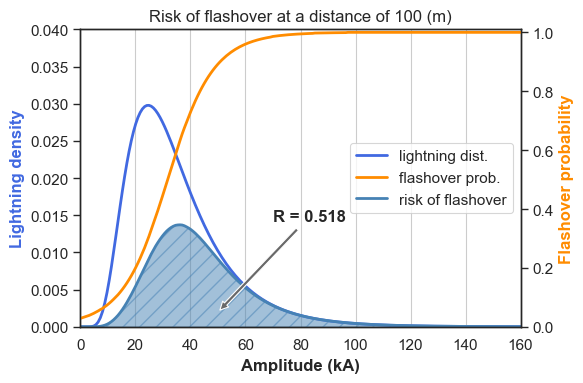

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
ax_twin = ax.twinx()  # second y-axis
ax.set_title(f"Risk of flashover at a distance of {D} (m)")
l1 = ax.plot(yv, pdfi, c='royalblue', lw=2, label='lightning dist.')
l2 = ax.plot(yv, pdfi*y_hat[D][:,1], c='steelblue', lw=2, label='risk of flashover')
ax.fill_between(yv, 0, pdfi*y_hat[D][:,1], color='steelblue', alpha=0.5, hatch='//',
                label='risk of flashover')
ax.set_xlim(0, yv.max())
ax.set_ylim(0, 0.04)
l3 = ax_twin.plot(yv, y_hat[D][:,1], c='darkorange', lw=2, label='flashover prob.')
lns = l1 + l3 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')
ax_twin.annotate('R = {:.3f}'.format(risk_values[D]),
                 xy=(50, 0.05), xycoords='data',
                 xytext=(70, 0.4), textcoords='data',
                 arrowprops=dict(arrowstyle='simple', facecolor='dimgrey'),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontweight='bold')
ax.set_xlabel('Amplitude (kA)', fontweight='bold')
ax.set_ylabel('Lightning density', fontweight='bold')
ax.yaxis.label.set_color('royalblue')
ax_twin.set_ylabel('Flashover probability', fontweight='bold')
ax_twin.yaxis.label.set_color('darkorange')
ax_twin.set_ylim(0, 1.01)
ax.grid(axis='x')
fig.tight_layout()
#plt.savefig('risk.png', dpi=600)
plt.show()

##### Statistical Safety Factor

In [40]:
# Statistical safety factor (gama) is the quotient of a statistical overvoltage 
# (Vs) and a statistical withstand voltage (Vw): gama = Vs/Vw. Statistical 
# overvoltage is the amplitude which has only a 2% chance to cause a flashover.
# Statistical withstand is the value at which there is only a 10% chance of 
# flashover. We can adapt this reasoning here, but with the lightning current 
# amplitudes, such that Vs is taken at 10% and Vw at 10% chance, regarding the
# currents instead of voltages.

# Lightning amplitudes probability
cdf_values_lightning = utils.cdf_from_pdf(np.nan_to_num(pdfi))
inverse_cdf_lightning = interpolate.interp1d(cdf_values_lightning, yv)
Vs = inverse_cdf_lightning(0.9)  # 10% probability
print(f'Vs(10%) = {Vs:.2f} (kA)')

gama_values = []
for d in distances:
    print(f'\nDistance: {d} (m)')
    # Flashover probability
    inverse_cdf_flashover = interpolate.interp1d(y_hat[d][:,1], yv)
    try:
        Vw = inverse_cdf_flashover(0.1)  # 10% probability
    except ValueError:
        Vw = 0.1
    print(f'Vw(10%) = {Vw:.2f} (kA)')
    # Statistical safety factor
    gama = Vw/Vs
    print(f'Safety factor: {gama:.3f}')
    gama_values.append(gama)

Vs(10%) = 57.38 (kA)

Distance: 0.0 (m)
Vw(10%) = 0.10 (kA)
Safety factor: 0.002

Distance: 50.0 (m)
Vw(10%) = 0.93 (kA)
Safety factor: 0.016

Distance: 100.0 (m)
Vw(10%) = 12.71 (kA)
Safety factor: 0.222

Distance: 150.0 (m)
Vw(10%) = 24.49 (kA)
Safety factor: 0.427

Distance: 200.0 (m)
Vw(10%) = 36.28 (kA)
Safety factor: 0.632

Distance: 250.0 (m)
Vw(10%) = 48.06 (kA)
Safety factor: 0.838

Distance: 350.0 (m)
Vw(10%) = 71.63 (kA)
Safety factor: 1.248


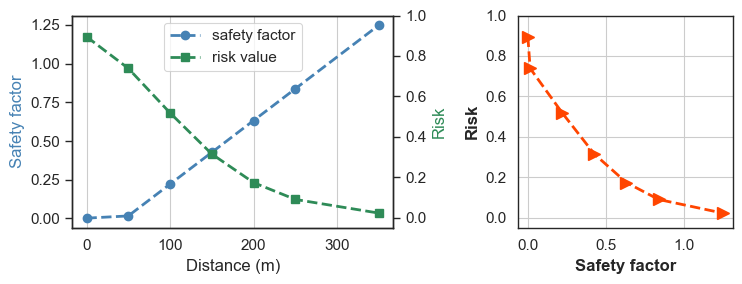

In [41]:
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 3),
                              gridspec_kw={'width_ratios': [1.5, 1]})
l1 = ax.plot(distances, gama_values, ls='--', c='steelblue', lw=2, marker='o', 
             markersize=6, label='safety factor')
ax_twin = ax.twinx()
l2 = ax_twin.plot(distances, risk_values.values(), ls='--', c='seagreen', lw=2, 
                  marker='s', markersize=6, label='risk value')
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper center')
ax.grid(which='major', axis='x')
ax_twin.set_ylabel('Risk')
ax_twin.set_ylim(-0.05, 1)
ax_twin.yaxis.label.set_color('seagreen')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Safety factor')
ax.yaxis.label.set_color('steelblue')
ax2.plot(gama_values, risk_values.values(), ls='--', c='orangered', lw=2,
         marker='>', markersize=8)
ax2.set_xlabel('Safety factor', fontweight='bold')
ax2.set_ylabel('Risk', fontweight='bold')
ax2.grid(which='major', axis='both')
ax2.set_ylim(-0.05, 1)
fig.tight_layout()
plt.savefig('safety_factor.png', dpi=600)
plt.show()

In [42]:
xdata = np.array(gama_values)
ydata = np.array(list(risk_values.values()))
uncertainties = np.exp(-3*xdata)  # exponential weighting
# Least-squares fit using Levenberg-Marquardt algorithm
popt, _ = optimize.curve_fit(distlines.risk_curve_fit, xdata, ydata, 
                             sigma=uncertainties, absolute_sigma=True)

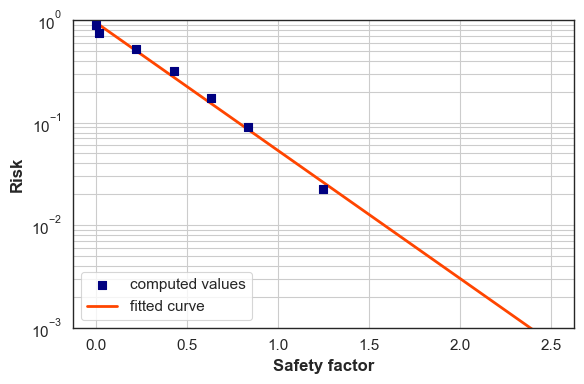

In [43]:
xnew = np.linspace(0, 2.5, 100)  # support
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(xdata, ydata, color='navy', marker='s', s=40, 
        label='computed values', zorder=100)
ax.plot(xnew, distlines.risk_curve_fit(xnew, *popt), c='orangered', 
        ls='-', lw=2, label='fitted curve')
ax.set_yscale('log', base=10)
ax.legend(loc='lower left')
ax.grid(which='both')
ax.set_xlabel('Safety factor', fontweight='bold')
ax.set_ylabel('Risk', fontweight='bold')
ax.set_ylim(1e-3, 1)
fig.tight_layout()
plt.savefig('risk_safety_factor.png', dpi=600)
plt.show()

In [44]:
R2 = np.corrcoef(ydata, distlines.risk_curve_fit(xdata, *popt))
R2[0,1]

0.9896562654220813

In [45]:
xv = np.linspace(0, XMAX, 200)
amplitudes = np.array([5., 15., 30., 60.])
y_hat = {}
for a in amplitudes:
    yv = np.array([a]*xv.size)
    X_values = np.c_[xv, yv]
    y_hat[a] = search.predict_proba(X_values)

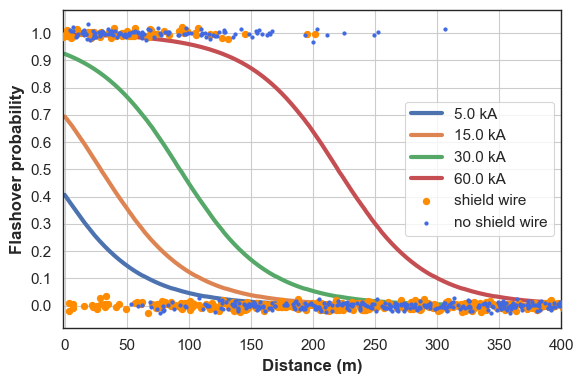

In [46]:
# Plot probability distributions for different amplitudes
sandbox.marginal_plot(amplitudes, xv, y_hat, g, 'dist', 'Distance (m)', xmax=400,
                      save_fig=False)

#### Test existing model with a new distribution line

In [47]:
# 10 m high distribution line
g = groups.get_group(12)
g.reset_index(inplace=True)
X_data_new_line = g[['dist', 'ampl']]  # add features here
y_data_new_line = g['flash']

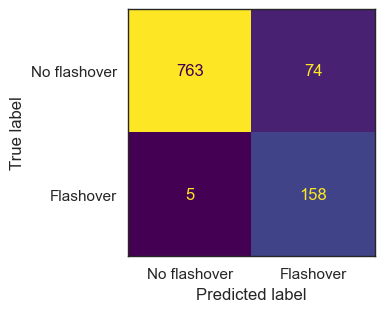

In [48]:
# Plot confusion matrix for estimator
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_estimator(
    search, X_data_new_line, y_data_new_line, 
    display_labels=['No flashover', 'Flashover'],
    # normalize='all',
    colorbar=False,
    ax=ax,
)
fig.tight_layout()
plt.show()

In [49]:
y_test_hat = search.predict(X_data_new_line)
# Display classification report
print(classification_report(
      y_data_new_line, y_test_hat, 
      target_names=['No flashover', 'Flashover']))

              precision    recall  f1-score   support

No flashover       0.99      0.91      0.95       837
   Flashover       0.68      0.97      0.80       163

    accuracy                           0.92      1000
   macro avg       0.84      0.94      0.88      1000
weighted avg       0.94      0.92      0.93      1000



### Using additional data features in model building

Now we can extend the model with additional features from the original dataset to see how that reflects on the model's prediction performance (accuracy).

In [50]:
# Use categorical features?
categoricals = False

if categoricals:
    # Using both numerical and categorical features.
    # 1) Split data into train and test sets.
    # 2) Transform both sets by fitting on the train set only.
    # Prepare the pipeline for processing categorical features:
    data_labels = data['flash']
    data_features = data.drop('flash', axis=1)
    categorical_features = ['EGM', 'ind']
    numerical_features = ['dist', 'ampl', 'front', 'shield', 'veloc', 'Ri', 
                          'CFO', 'height']
    column_names = [str(x) for x in np.arange(9)]  # for 'EGM' & 'ind' columns
    column_names.extend(numerical_features)
    # One-hot encode only the categorical features:
    transformer_pipeline = ColumnTransformer(
        [('categories', OneHotEncoder(sparse=False), categorical_features)],
        remainder='passthrough',
        n_jobs=-1
    )
    # Split data into training and test sets.
    X_data, y, X_test_data, y_test = sandbox.train_test_shuffle_split(
        data_features, data_labels
    )
    # Transform data with a transformer pipeline.
    X_transformed = transformer_pipeline.fit_transform(X_data)
    X_test_transformed  = transformer_pipeline.transform(X_test_data)
    # Pandas dataframes of transformed data with proper column names.
    X = pd.DataFrame(X_transformed, columns=column_names)
    X_test = pd.DataFrame(X_test_transformed, columns=column_names)
else:
    # Using only numerical features while droping categoricals.
    X_data = data.drop(['flash', 'EGM', 'ind'], axis=1)
    y_data = data['flash']
    # Split data into training and test sets.
    X, y, X_test, y_test = sandbox.train_test_shuffle_split(
        X_data, y_data
    )

In [51]:
# Model training with hyperparameters optimization
model = sandbox.bagging_ensemble_svm(n_models, X, y, sample_pct=0.7, 
                                     weighted=False, sampling='Stratified',
                                     weights_loss_type='balanced_focal_loss')

Train model 1 of 3:
Working ...
Execution time (hour:min:sec): 0:01:06.274964
estimator__C :: 2.977482592202902
estimator__gamma :: auto
estimator__kernel :: linear
preprocess :: StandardScaler()
Train model 2 of 3:
Working ...
Execution time (hour:min:sec): 0:02:34.717923
estimator__C :: 172.9747347627687
estimator__gamma :: auto
estimator__kernel :: linear
preprocess :: None
Train model 3 of 3:
Working ...
Execution time (hour:min:sec): 0:00:02.338209
estimator__C :: 14.242515214540727
estimator__gamma :: scale
estimator__kernel :: rbf
preprocess :: None
Aggregating predictions:
With equal weights.
Create voting ensemble:
Working ...
Done.


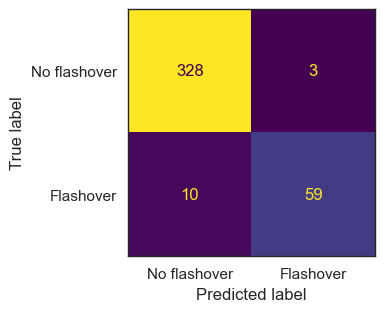

In [52]:
# Plot confusion matrix for estimator
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    display_labels=['No flashover', 'Flashover'],
    colorbar=False,
    ax=ax,
)
fig.tight_layout()
plt.show()

In [53]:
y_hat = model.predict(X_test)
# Display classification report
print(classification_report(
      y_test, y_hat, 
      target_names=['No flashover', 'Flashover']))

              precision    recall  f1-score   support

No flashover       0.97      0.99      0.98       331
   Flashover       0.95      0.86      0.90        69

    accuracy                           0.97       400
   macro avg       0.96      0.92      0.94       400
weighted avg       0.97      0.97      0.97       400



__Note__: We can see from the confusion matrix and the classification report that the newly trained model with additional features has much better overall performance, compared to the previous model that was trained with only two features. Hence, this approach enables building a single model that can be employed for flashover analysis on distribution lines of different heights and geometry.

#### CLP from the model with additional features

In [54]:
support_vectors = []
for i in range(n_models):
    supports = model.estimators_[i].support_vectors_
    support_vectors.append(supports)
support_vectors = np.concatenate(support_vectors)
vectors = np.unique(support_vectors, axis=0)

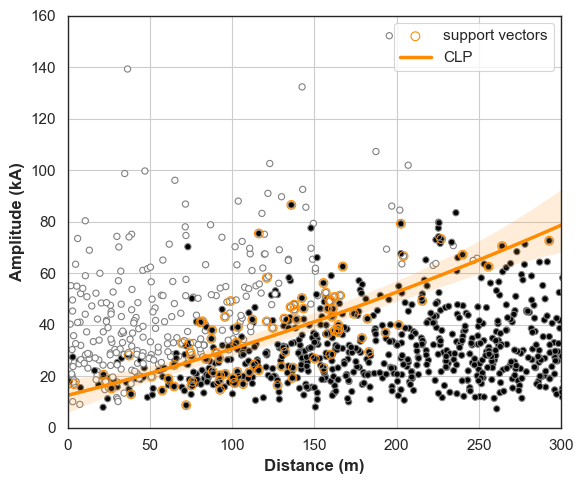

In [55]:
if categoricals:
    dim = 9
else:
    dim = 0
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(X.values[:,dim], X.values[:,dim+1], c=y, edgecolors='grey', 
           cmap=plt.cm.bone, s=20)
ax.scatter(vectors[:,dim], vectors[:,dim+1], facecolor='none', 
           edgecolor='darkorange', s=40, label='support vectors')
# Fit and plot CLP regression curve through the support vectors
sns.regplot(x=vectors[:,dim], y=vectors[:,dim+1], fit_reg=True, 
            order=2,  # second order polynomial
            truncate=False, scatter=False, color='darkorange',
            line_kws={'lw': 2.5},
            ax=ax, label='CLP')
ax.legend(loc='upper right', frameon='fancy', fancybox=True)
ax.set_xlabel('Distance (m)', fontweight='bold')
ax.set_ylabel('Amplitude (kA)', fontweight='bold')
ax.set_xlim(0,300)
ax.set_ylim(0,160)
ax.grid()
fig.tight_layout()
plt.show()